In [1]:
!pip install opendatasets
!pip install pandas
!pip install torchmetrics

  Using cached opendatasets-0.1.22-py3-none-any.whl.metadata (9.2 kB)
  Using cached kaggle-1.7.4.2-py3-none-any.whl.metadata (16 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
Using cached kaggle-1.7.4.2-py3-none-any.whl (173 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.1 MB/s eta 0:00:0000:01


In [1]:
import opendatasets as od 
import pandas 

od.download( 
    "https://www.kaggle.com/datasets/msambare/fer2013/data") 


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


In [1]:
import os

# List the files in the downloaded folder
dataset_path = "fer2013"
os.listdir(dataset_path)

['train', 'test']

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')


Using GPU


In [16]:

from torchvision import transforms
import numpy as np
import random as random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    
])

# Load full training set
full_dataset = datasets.ImageFolder(root="fer2013/train", transform=transform)

print(full_dataset)

#target_class_name = "disgust"

#target_class_idx = full_dataset.class_to_idx[target_class_name]

# Duplicate and augment target class samples
#augmented_samples = []
#for path, label in dataset.samples:
    #if label == target_class_idx:
        # Load image and apply extra transform
        #image = Image.open(path).convert('RGB')
        #transformed_image = extra_transform(image)
        #augmented_samples.append((transformed_image, label))

# Split 80/20
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Test set
test_dataset = datasets.ImageFolder(root="fer2013/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Dataset ImageFolder
    Number of datapoints: 28709
    Root location: fer2013/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [17]:
# Dataloaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# # Get dataset sizes
# train_N = len(train_dataset)
# valid_N = len(valid_dataset)

In [19]:

# Hyperparameters
n_classes = 7  # FER2013 has 7 emotions
IMG_CHS = 1  # Grayscale images
kernel_size = 3
flattened_img_size = 75 * 3 * 3

# Define the CNN Model
model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 48 x 48
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 24 x 24
    
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 24 x 24
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 12 x 12
    
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 12 x 12
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, stride=2),  # 75 x 6 x 6
    
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(75 * 6 * 6, 512),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, n_classes)  # Output 7 classes
)


In [20]:
device = torch.device("cuda" if flag_cuda else "cpu")
model = model.to(device)

In [21]:
# Define Loss and Optimizer
weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], device=device)
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters())

In [22]:
# Function to calculate batch accuracy
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [23]:
# Validation function
def validate(get_preds=False):
    loss = 0
    accuracy = 0
    valid_preds = []
    valid_targets = []
    model.eval()
    valid_N = len(valid_loader.dataset)
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)

            if(get_preds):
                preds = torch.argmax(output, dim=1)
                valid_preds.extend(preds.cpu().numpy())
                valid_targets.extend(y.cpu().numpy())
    
    print(f'Valid - Loss: {loss:.4f} Accuracy: {accuracy:.4f}')
    if(get_preds):
        return np.array(valid_targets), np.array(valid_preds)

# Training function
def train(get_preds=False):
    loss = 0
    accuracy = 0
    train_preds = []
    train_targets = []
    model.train()
    train_N = len(train_loader.dataset)
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)

        if(get_preds):
            preds = torch.argmax(output, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(y.cpu().numpy())
    
    print(f'Train - Loss: {loss:.4f} Accuracy: {accuracy:.4f}')
    if(get_preds):
        return np.array(train_targets), np.array(train_preds)


In [24]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
def summaryPerf(yTrain,yTrainHat,y,yHat):
    # Plotting confusion matrix for the non-training set:
    cm = metrics.confusion_matrix(y,yHat,normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                                  ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
    disp.plot()

    # Displaying metrics for training and non-training sets
    print('Training:  Acc = {:4.3f}'.format(metrics.accuracy_score(yTrain,yTrainHat)))
    print('Training:  BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(yTrain,yTrainHat)))
    print('Validation: Acc = {:4.3f}'.format(metrics.accuracy_score(y,yHat)))
    print('Validation: BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(y,yHat)))

In [25]:
import torchmetrics
def compute_f1():
    model.eval()
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=7).to("cuda")
    f1_metric.reset()
    
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)  # Keep everything on GPU
            output = model(x)
            predictions = torch.argmax(output, dim=1)

            f1_metric.update(predictions, y)  # Directly update the metric
    print(f"F1_score: {f1_metric.compute().item():.4f}")


In [26]:
# Training loop
epochs = 30

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}/{epochs}')
    train()
    validate()
    #compute_f1()

Epoch: 1/30
Train - Loss: 598.4663 Accuracy: 0.3405
Valid - Loss: 133.6388 Accuracy: 0.4345
Epoch: 2/30
Train - Loss: 510.3927 Accuracy: 0.4455
Valid - Loss: 121.6924 Accuracy: 0.4885
Epoch: 3/30
Train - Loss: 478.7819 Accuracy: 0.4827
Valid - Loss: 118.1774 Accuracy: 0.5035
Epoch: 4/30
Train - Loss: 457.0525 Accuracy: 0.5120
Valid - Loss: 114.9945 Accuracy: 0.5077
Epoch: 5/30
Train - Loss: 438.2923 Accuracy: 0.5261
Valid - Loss: 110.1922 Accuracy: 0.5425
Epoch: 6/30
Train - Loss: 423.8887 Accuracy: 0.5477
Valid - Loss: 110.2157 Accuracy: 0.5272
Epoch: 7/30
Train - Loss: 410.5530 Accuracy: 0.5630
Valid - Loss: 107.8425 Accuracy: 0.5482
Epoch: 8/30
Train - Loss: 397.1173 Accuracy: 0.5717
Valid - Loss: 104.9253 Accuracy: 0.5571
Epoch: 9/30
Train - Loss: 388.7575 Accuracy: 0.5861
Valid - Loss: 103.1370 Accuracy: 0.5629
Epoch: 10/30
Train - Loss: 378.4089 Accuracy: 0.5994
Valid - Loss: 101.9527 Accuracy: 0.5705
Epoch: 11/30
Train - Loss: 369.2810 Accuracy: 0.6049
Valid - Loss: 103.5658 Acc

Train - Loss: 249.2998 Accuracy: 0.7307
Valid - Loss: 109.3272 Accuracy: 0.5866
RESULTS:

Training:  Acc = 0.731
Training:  BalAcc = 0.703
Validation: Acc = 0.587
Validation: BalAcc = 0.527


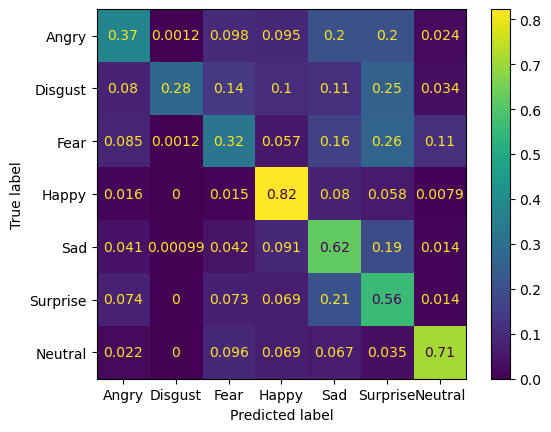

In [27]:
yTrain, yTrainHat = train(get_preds=True)
yVal, yValHat = validate(get_preds=True)

# Define Loss and Optimizer
weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], device=device)
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters())

print('RESULTS:\n')
summaryPerf(yTrain, yTrainHat, yVal, yValHat)